<a href="https://colab.research.google.com/github/knsg16/flop_or_foul/blob/main/flop_or_foul.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## GoogleDriveと連携

In [ ]:
from google.colab import drive
import shutil
import os

# Google Driveのマウント
drive.mount('/content/drive')

# Google Drive内の'data_directory'をGoogle Colabのカレントディレクトリにコピー
shutil.copytree('/content/drive/My Drive/data_directory', './data_directory')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


'./data_directory'

## 動画の作成

In [ ]:
import cv2
import numpy as np
import os

def create_sample_video(filename, label="foul"):
    width, height = 640, 480
    fps = 30
    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    out = cv2.VideoWriter(filename, fourcc, fps, (width, height))

    for _ in range(30*5):  # 5 seconds video
        img = np.random.randint(0, 256, (480, 640, 3), dtype=np.uint8)

        if label == "foul":
            cv2.putText(img, 'FOUL', (250, 250), cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 0, 255), 2)
        else:
            cv2.putText(img, 'FLOP', (250, 250), cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 255, 0), 2)

        out.write(img)

    out.release()

# Create directories
os.makedirs("data_directory/train/foul", exist_ok=True)
os.makedirs("data_directory/train/flop", exist_ok=True)
os.makedirs("data_directory/test/foul", exist_ok=True)
os.makedirs("data_directory/test/flop", exist_ok=True)

# Generate sample videos
create_sample_video("data_directory/train/foul/video1.mp4", "foul")
create_sample_video("data_directory/train/flop/video1.mp4", "flop")
create_sample_video("data_directory/test/foul/video1.mp4", "foul")
create_sample_video("data_directory/test/flop/video1.mp4", "flop")


## 動画データの前処理

In [ ]:
import cv2
import os
import numpy as np

# 定数定義
FRAME_SIZE = (64, 64)  # 使用するモデルに合わせて変更
SEQUENCE_LENGTH = 10  # 連続するフレームの数

# ビデオからフレームのシーケンスを取得する関数
def extract_frames_from_video(video_path, frame_size, sequence_length):
    cap = cv2.VideoCapture(video_path)
    frames = []

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        # リサイズと正規化
        frame = cv2.resize(frame, frame_size)
        frame = frame / 255.0

        frames.append(frame)

    cap.release()

    sequences = []

    # フレームをシーケンスに分割
    for i in range(len(frames) - sequence_length):
        sequences.append(frames[i:i+sequence_length])

    return sequences

# ディレクトリから全てのビデオを前処理する関数
def preprocess_videos_from_directory(directory_path, frame_size, sequence_length):
    sequences = []
    labels = []

    for label_folder in os.listdir(directory_path):
        folder_path = os.path.join(directory_path, label_folder)
        if os.path.isdir(folder_path):
            for video_file in os.listdir(folder_path):
                video_path = os.path.join(folder_path, video_file)
                video_sequences = extract_frames_from_video(video_path, frame_size, sequence_length)
                sequences.extend(video_sequences)

                # ラベル情報を追加
                if label_folder == "foul":
                    labels.extend([[1, 0]] * len(video_sequences))
                elif label_folder == "flop":
                    labels.extend([[0, 1]] * len(video_sequences))

    return np.array(sequences), np.array(labels)

# 前処理実行
X_train, y_train = preprocess_videos_from_directory("data_directory/train", FRAME_SIZE, SEQUENCE_LENGTH)
X_test, y_test = preprocess_videos_from_directory("data_directory/test", FRAME_SIZE, SEQUENCE_LENGTH)


## モデルの作成


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam


In [ ]:
def create_3dcnn_model(input_shape, num_classes=2):
    model = Sequential()

    # 第1層
    model.add(Conv3D(64, kernel_size=(3, 3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    # 第2層
    model.add(Conv3D(128, kernel_size=(3, 3, 3), activation='relu'))
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    # フラット化して全結合層に
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))

    # 出力層
    model.add(Dense(num_classes, activation='softmax'))

    return model


### モデルのコンパイルとサマリの表示：

In [ ]:
input_shape = (SEQUENCE_LENGTH, FRAME_SIZE[0], FRAME_SIZE[1], 3)  # フレーム数、高さ、幅、チャネル数
model = create_3dcnn_model(input_shape)

model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 8, 62, 62, 64)     5248      
                                                                 
 max_pooling3d (MaxPooling3D  (None, 4, 31, 31, 64)    0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 2, 29, 29, 128)    221312    
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 1, 14, 14, 128)   0         
 3D)                                                             
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 512)               1

### このモデルを使用して訓練データで訓練を行うには以下のように実行します

In [ ]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size=16)


Epoch 1/20
165/165 [==============================] - 20s 48ms/step - loss: 0.0869 - accuracy: 0.9688 - val_loss: 0.0043 - val_accuracy: 1.0000
Epoch 2/20
165/165 [==============================] - 7s 41ms/step - loss: 2.1156e-04 - accuracy: 1.0000 - val_loss: 0.0205 - val_accuracy: 0.9900
Epoch 3/20
165/165 [==============================] - 7s 41ms/step - loss: 3.6706e-04 - accuracy: 1.0000 - val_loss: 0.0035 - val_accuracy: 1.0000
Epoch 4/20
165/165 [==============================] - 7s 41ms/step - loss: 0.1541 - accuracy: 0.9817 - val_loss: 0.0217 - val_accuracy: 0.9900
Epoch 5/20
165/165 [==============================] - 7s 41ms/step - loss: 0.0419 - accuracy: 0.9947 - val_loss: 1.1395e-04 - val_accuracy: 1.0000
Epoch 6/20
165/165 [==============================] - 7s 41ms/step - loss: 6.4400e-05 - accuracy: 1.0000 - val_loss: 3.3781e-04 - val_accuracy: 1.0000
Epoch 7/20
165/165 [==============================] - 7s 42ms/step - loss: 1.3935e-05 - accuracy: 1.0000 - val_loss: 1.20

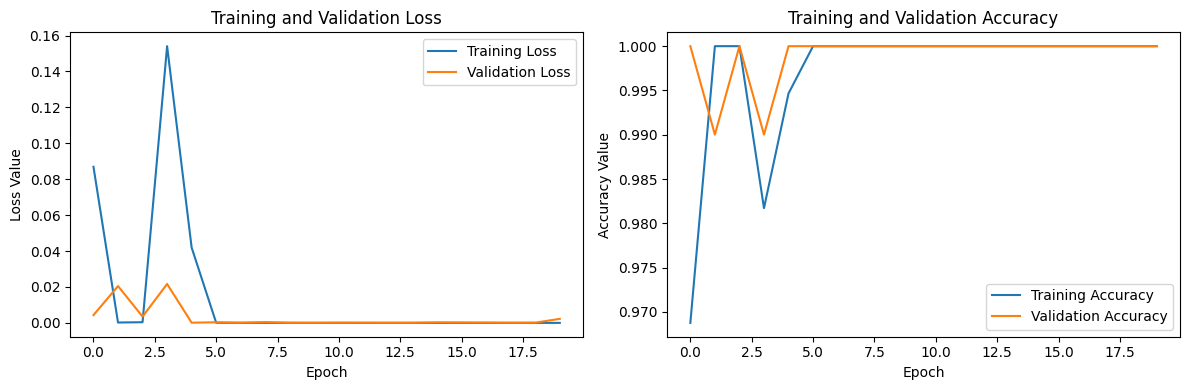

Epoch 1 - Training Accuracy: 0.9688, Validation Accuracy: 1.0000
Epoch 2 - Training Accuracy: 1.0000, Validation Accuracy: 0.9900
Epoch 3 - Training Accuracy: 1.0000, Validation Accuracy: 1.0000
Epoch 4 - Training Accuracy: 0.9817, Validation Accuracy: 0.9900
Epoch 5 - Training Accuracy: 0.9947, Validation Accuracy: 1.0000
Epoch 6 - Training Accuracy: 1.0000, Validation Accuracy: 1.0000
Epoch 7 - Training Accuracy: 1.0000, Validation Accuracy: 1.0000
Epoch 8 - Training Accuracy: 1.0000, Validation Accuracy: 1.0000
Epoch 9 - Training Accuracy: 1.0000, Validation Accuracy: 1.0000
Epoch 10 - Training Accuracy: 1.0000, Validation Accuracy: 1.0000
Epoch 11 - Training Accuracy: 1.0000, Validation Accuracy: 1.0000
Epoch 12 - Training Accuracy: 1.0000, Validation Accuracy: 1.0000
Epoch 13 - Training Accuracy: 1.0000, Validation Accuracy: 1.0000
Epoch 14 - Training Accuracy: 1.0000, Validation Accuracy: 1.0000
Epoch 15 - Training Accuracy: 1.0000, Validation Accuracy: 1.0000
Epoch 16 - Training

In [ ]:
import matplotlib.pyplot as plt

# 損失のプロット
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.legend()

# 精度のプロット
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy Value')
plt.legend()

plt.tight_layout()
plt.show()

# エポック数の取得
num_epochs = len(history.history['accuracy'])

# エポックごとのトレーニングと検証の精度を表示
for epoch in range(num_epochs):
    train_acc = history.history['accuracy'][epoch]
    val_acc = history.history['val_accuracy'][epoch]
    print(f"Epoch {epoch + 1} - Training Accuracy: {train_acc:.4f}, Validation Accuracy: {val_acc:.4f}")



In [ ]:
import tensorflow as tf

# モデルを.h5形式で保存
model.save('sample_model.h5')

In [ ]:
# 必要なライブラリのインポート
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
from IPython.display import display, HTML
from base64 import b64encode
from google.colab import files

model = tf.keras.models.load_model('/content/sample_model.h5')

# 動画をアップロード
uploaded = files.upload()
for fn in uploaded.keys():
  video_path = fn

cap = cv2.VideoCapture(video_path)
fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter('output.avi', fourcc, 20.0, (int(cap.get(3)), int(cap.get(4))))

frames = []

while(cap.isOpened()):
    ret, frame = cap.read()
    if ret:
        frame_resized = cv2.resize(frame, (64, 64))
        frames.append(frame_resized)
        if len(frames) == 10:
            input_data = np.expand_dims(frames, axis=0)
            prediction = model.predict(input_data)
            label = "foul" if prediction[0][0] > 0.5 else "flop"
            cv2.putText(frame, label, (10,30), cv2.FONT_HERSHEY_SIMPLEX, 2.0, (0,0,255), 2, cv2.LINE_AA)
            out.write(frame)
            frames.pop(0)
    else:
        break

cap.release()
out.release()

# AVIをMP4に変換する前に、既存のoutput.mp4を削除
if os.path.exists('output.mp4'):
    os.remove('output.mp4')

# AVIをMP4に変換
!ffmpeg -i output.avi output.mp4

# 動画の再生
mp4 = open('output.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
display(HTML("""
<video width=400 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url))


Saving flop.mp4 to flop.mp4
1/1 [==============================] - 0s 20ms/step
ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora -